LSTM óbitos de Covid

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [33]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
def predict_until_new_year(dataset, look_back=1):
    predictArr = []
    predictArr = np.array([], dtype=np.float64)
    predictArr = predictArr.astype('float32').reshape(-1,1)
    X = np.array(dataset.newDeaths)
    X = X.astype('float32').reshape(-1,1)
    ano_novo = datetime.strptime('2021-12-31', '%Y-%m-%d')
    hoje = datetime.today()
    dias_ate_ano_novo = abs((ano_novo - hoje).days)
    print(f"dias até o ano novo {dias_ate_ano_novo}")
    for i in range(dias_ate_ano_novo, 0, -1):
        print(f"prevendo taxa de óbitos para o dia {i} até o ano novo")
        data_para_previsao = scaler.fit_transform(X[look_back*-1:])
        data_para_previsao = np.reshape(data_para_previsao, (1, data_para_previsao.shape[0], 1))
        predict = model.predict(data_para_previsao)
        invpredict = scaler.inverse_transform(predict)
        X = np.append(X, invpredict, axis=0)
        predictArr = np.append(predictArr, invpredict, axis=0)
    return predictArr

def predict_for_next_year(dataset, look_back=1):
    predictArr = []
    predictArr = np.array([], dtype=np.float64)
    predictArr = predictArr.astype('float32').reshape(-1,1)
    X = np.array(dataset.newDeaths)
    X = X.astype('float32').reshape(-1,1)
    print(f"Prevendo óbitos para o próximo ano!!")
    for i in range(1, 365, 1):
        print(f"prevendo taxa de óbitos para o dia {i} do próximo ano")
        data_para_previsao = scaler.fit_transform(X[look_back*-1:])
        data_para_previsao = np.reshape(data_para_previsao, (1, data_para_previsao.shape[0], 1))
        predict = model.predict(data_para_previsao)
        invpredict = scaler.inverse_transform(predict)
        X = np.append(X, invpredict, axis=0)
        predictArr = np.append(predictArr, invpredict, axis=0)
    return predictArr

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv")

In [16]:
# change date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# print all available columns
print(df.columns)

# filter data for Brazil, and show only the specified columns
data_BR = df.query("state == 'TOTAL'")[['date', 'newDeaths']]

# display the dataframe
data_BR

Index(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants'],
      dtype='object')


,date,newDeaths
1,2020-02-25,0
3,2020-02-26,0
5,2020-02-27,0
7,2020-02-28,0
9,2020-02-29,0
...,...,...
16281,2021-10-14,572
16309,2021-10-15,507
16337,2021-10-16,465
16365,2021-10-17,123


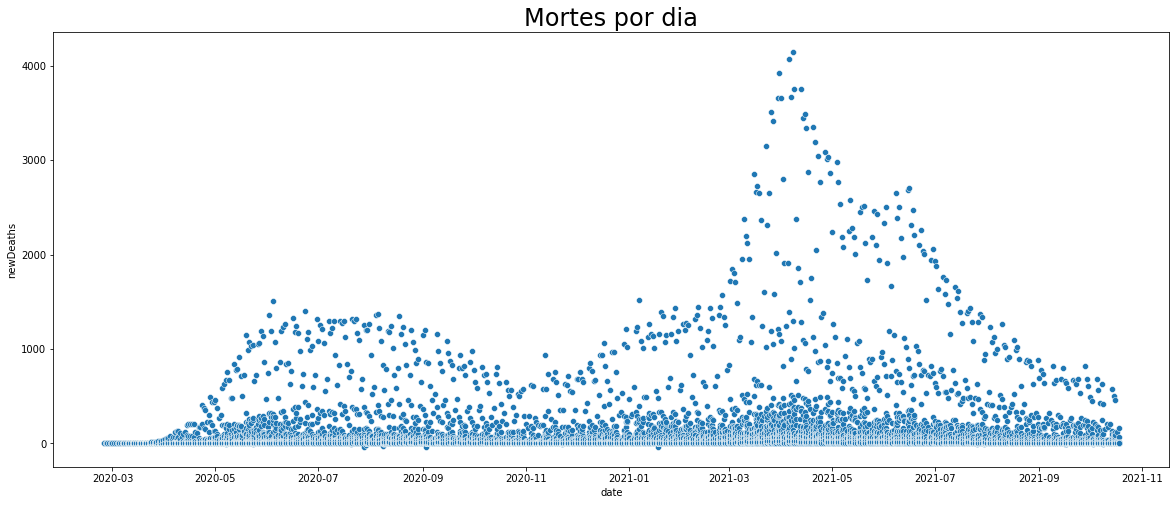

In [17]:
fig = plt.figure(figsize=(20,8))
sns.scatterplot(x=df.date, y=df.newDeaths)
plt.title('Mortes por dia', size=24)
plt.show()

<AxesSubplot:xlabel='newDeaths', ylabel='Count'>

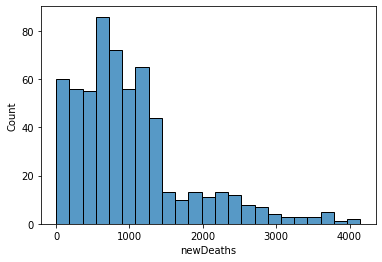

In [18]:
sns.histplot(data_BR.newDeaths)

# Previsão

In [19]:
X = np.array(data_BR.newDeaths)
X = X.astype('float32').reshape(-1,1)

In [20]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:len(X),:]
test =  X[train_size:len(X),:]

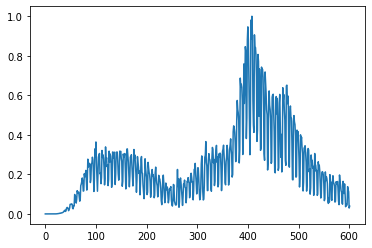

In [22]:
plt.plot(train)

In [11]:
best = 0
best_mse = np.Infinity
for n in range(1, 21, 1):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1),return_sequences=True, dropout=0.2))
    model.add(LSTM(64, input_shape=(128, 1), dropout=0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

KeyboardInterrupt: 

In [23]:
# quantidade de atrasos
look_back = 17

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [24]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1),return_sequences=True, dropout=0.2))
model.add(LSTM(64, input_shape=(128, 1), dropout=0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 17, 128)           66560     
_________________________________________________________________
lstm_44 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [16]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_covid_mortes.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Train on 583 samples, validate on 163 samples
Epoch 1/100
583/583 [==============================] - 16s 27ms/step - loss: 0.0302 - val_loss: 0.0187

Epoch 00001: val_loss improved from inf to 0.01870, saving model to ./modelo_lstm_covid_mortes.hdf5
Epoch 2/100
583/583 [==============================] - 18s 31ms/step - loss: 0.0254 - val_loss: 0.0285

Epoch 00002: val_loss did not improve from 0.01870
Epoch 3/100
583/583 [==============================] - 18s 30ms/step - loss: 0.0268 - val_loss: 0.0202

Epoch 00003: val_loss did not improve from 0.01870
Epoch 4/100
583/583 [==============================] - 18s 31ms/step - loss: 0.0236 - val_loss: 0.0161

Epoch 00004: val_loss improved from 0.01870 to 0.01610, saving model to ./modelo_lstm_covid_mortes.hdf5
Epoch 5/100
583/583 [==============================] - 18s 32ms/step - loss: 0.0213 - val_loss: 0.0229 ETA: - ETA: 7s - loss: 0.018 - ETA: 7s - loss:

Epoch 00005: val_loss did not improve from 0.01610
Epoch 6/100
583/583 [=========

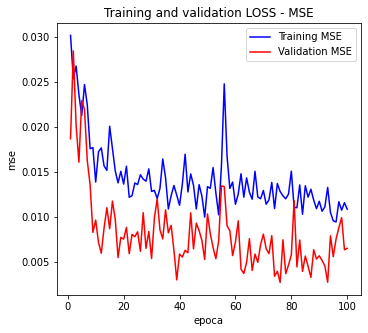

In [17]:
plot_history(history)

In [25]:
model = load_model("./modelo_lstm_covid_mortes.hdf5")
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [26]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [27]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 304.61 RMSE
Test Score: 218.42 RMSE


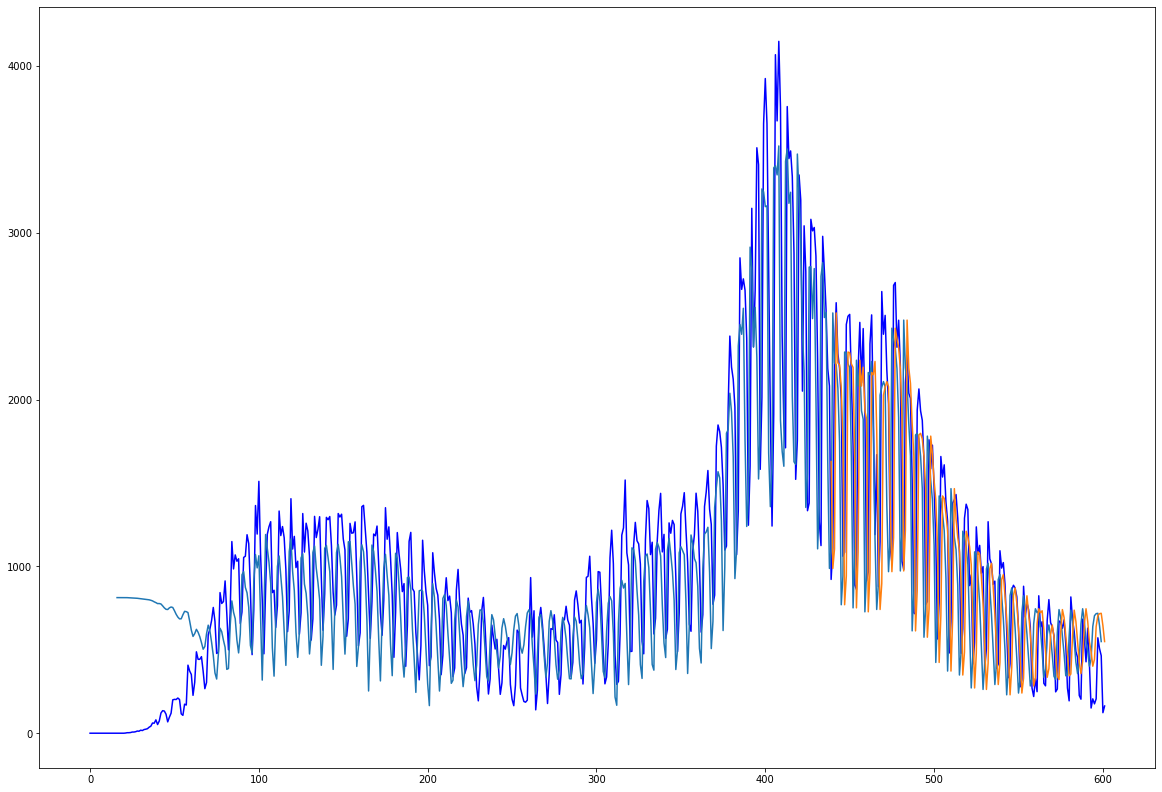

In [28]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(X)-len(testPredict):len(X), :] = testPredict

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
previsoes_final_ano = predict_until_new_year(data_BR, look_back)

dias até o ano novo 73
prevendo taxa de óbitos para o dia 73 até o ano novo
prevendo taxa de óbitos para o dia 72 até o ano novo
prevendo taxa de óbitos para o dia 71 até o ano novo
prevendo taxa de óbitos para o dia 70 até o ano novo
prevendo taxa de óbitos para o dia 69 até o ano novo
prevendo taxa de óbitos para o dia 68 até o ano novo
prevendo taxa de óbitos para o dia 67 até o ano novo
prevendo taxa de óbitos para o dia 66 até o ano novo
prevendo taxa de óbitos para o dia 65 até o ano novo
prevendo taxa de óbitos para o dia 64 até o ano novo
prevendo taxa de óbitos para o dia 63 até o ano novo
prevendo taxa de óbitos para o dia 62 até o ano novo
prevendo taxa de óbitos para o dia 61 até o ano novo
prevendo taxa de óbitos para o dia 60 até o ano novo
prevendo taxa de óbitos para o dia 59 até o ano novo
prevendo taxa de óbitos para o dia 58 até o ano novo
prevendo taxa de óbitos para o dia 57 até o ano novo
prevendo taxa de óbitos para o dia 56 até o ano novo
prevendo taxa de óbitos

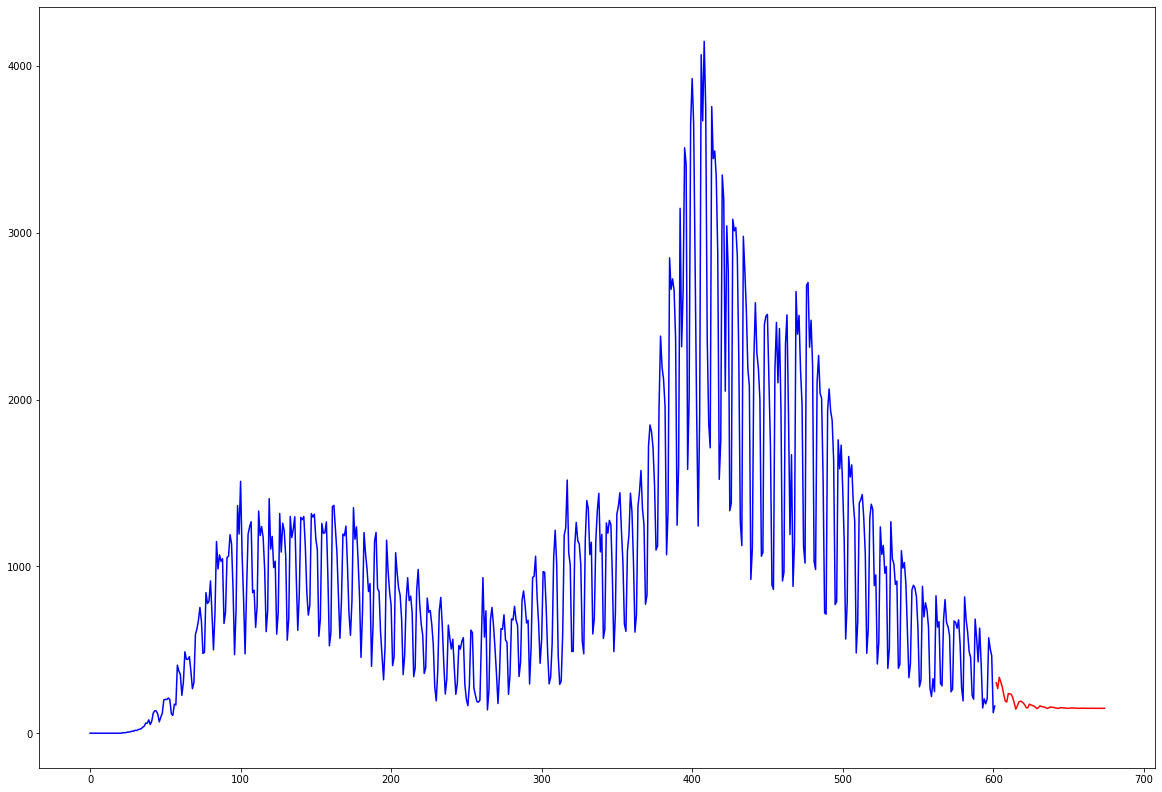

In [30]:
X = np.array(data_BR.newDeaths)
X = X.astype('float32').reshape(-1,1)

# Prepara o vetor para plotagem dos valores originais
originalX = np.empty([len(X)+len(previsoes_final_ano), ]).reshape(-1,1)
originalX[:, :] = np.nan
originalX[0:len(X), :] = X

# Prepara o vetor para plotagem do conjunto das predições
PredictPlot = np.empty_like(originalX)
PredictPlot[:, :] = np.nan
PredictPlot[len(X):len(X)+len(previsoes_final_ano), :] = previsoes_final_ano

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(originalX, color = 'b')
plt.plot(PredictPlot, color='r')
plt.show()

In [31]:
previsoes_final_ano

array([[302.3142 ],
       [267.8532 ],
       [335.1274 ],
       [309.6184 ],
       [277.33228],
       [232.3173 ],
       [192.62733],
       [186.82039],
       [237.1979 ],
       [237.05797],
       [232.75325],
       [211.88011],
       [180.06807],
       [144.3968 ],
       [163.08127],
       [186.96054],
       [192.52382],
       [188.22598],
       [181.1005 ],
       [169.2771 ],
       [152.37662],
       [152.44746],
       [173.68617],
       [170.20386],
       [166.99776],
       [162.97055],
       [156.76836],
       [147.59761],
       [153.02693],
       [163.80405],
       [159.85085],
       [158.4697 ],
       [156.0855 ],
       [152.62605],
       [147.97499],
       [152.6883 ],
       [157.34761],
       [155.61797],
       [154.63028],
       [152.8073 ],
       [150.76155],
       [148.52818],
       [151.1693 ],
       [153.91542],
       [152.49753],
       [151.77919],
       [150.80458],
       [149.69125],
       [148.81662],
       [150.25386],


In [34]:
previsoes_proximo_ano = predict_for_next_year(data_BR, look_back)

Prevendo óbitos para o próximo ano!!
prevendo taxa de óbitos para o dia 1 até o ano novo
prevendo taxa de óbitos para o dia 2 até o ano novo
prevendo taxa de óbitos para o dia 3 até o ano novo
prevendo taxa de óbitos para o dia 4 até o ano novo
prevendo taxa de óbitos para o dia 5 até o ano novo
prevendo taxa de óbitos para o dia 6 até o ano novo
prevendo taxa de óbitos para o dia 7 até o ano novo
prevendo taxa de óbitos para o dia 8 até o ano novo
prevendo taxa de óbitos para o dia 9 até o ano novo
prevendo taxa de óbitos para o dia 10 até o ano novo
prevendo taxa de óbitos para o dia 11 até o ano novo
prevendo taxa de óbitos para o dia 12 até o ano novo
prevendo taxa de óbitos para o dia 13 até o ano novo
prevendo taxa de óbitos para o dia 14 até o ano novo
prevendo taxa de óbitos para o dia 15 até o ano novo
prevendo taxa de óbitos para o dia 16 até o ano novo
prevendo taxa de óbitos para o dia 17 até o ano novo
prevendo taxa de óbitos para o dia 18 até o ano novo
prevendo taxa de ó

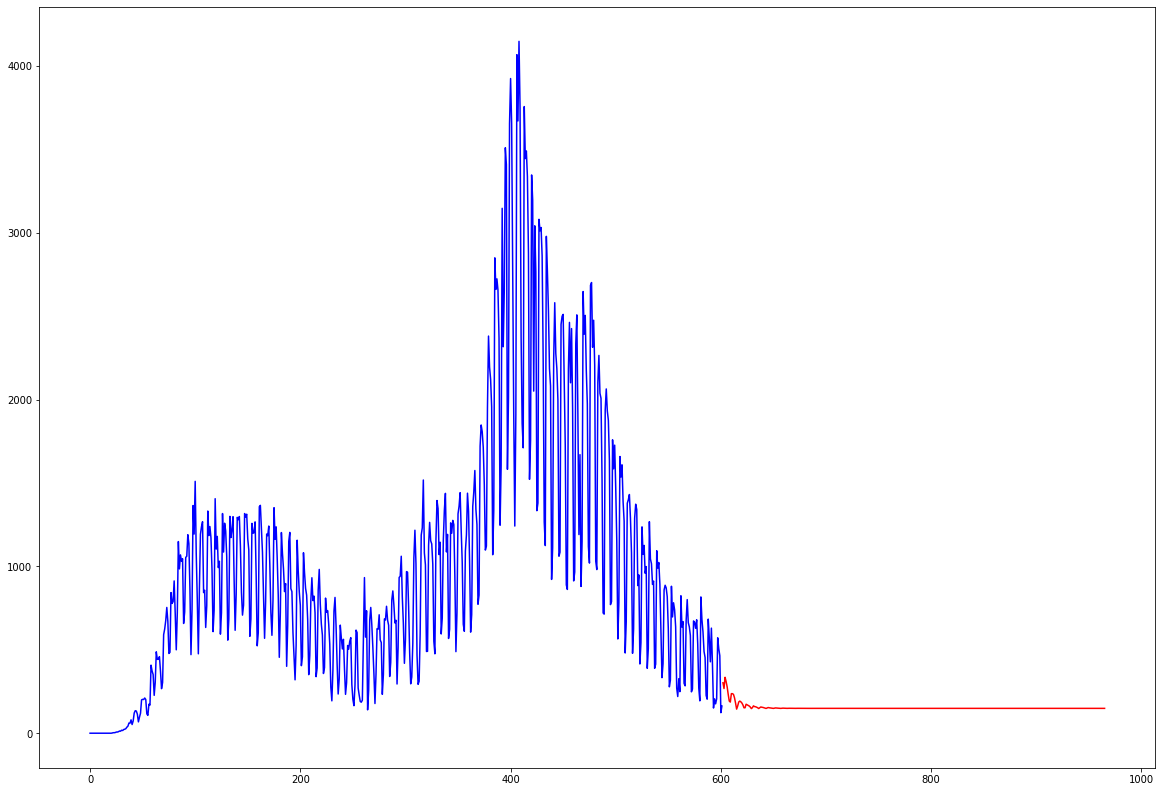

In [35]:
X = np.array(data_BR.newDeaths)
X = X.astype('float32').reshape(-1,1)

# Prepara o vetor para plotagem dos valores originais
originalX = np.empty([len(X)+len(previsoes_proximo_ano), ]).reshape(-1,1)
originalX[:, :] = np.nan
originalX[0:len(X), :] = X

# Prepara o vetor para plotagem do conjunto das predições
PredictPlot = np.empty_like(originalX)
PredictPlot[:, :] = np.nan
PredictPlot[len(X):len(X)+len(previsoes_proximo_ano), :] = previsoes_proximo_ano

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(originalX, color = 'b')
plt.plot(PredictPlot, color='r')
plt.show()

In [36]:
previsoes_proximo_ano

array([[302.3142 ],
       [267.8532 ],
       [335.1274 ],
       [309.6184 ],
       [277.33228],
       [232.3173 ],
       [192.62733],
       [186.82039],
       [237.1979 ],
       [237.05797],
       [232.75325],
       [211.88011],
       [180.06807],
       [144.3968 ],
       [163.08127],
       [186.96054],
       [192.52382],
       [188.22598],
       [181.1005 ],
       [169.2771 ],
       [152.37662],
       [152.44746],
       [173.68617],
       [170.20386],
       [166.99776],
       [162.97055],
       [156.76836],
       [147.59761],
       [153.02693],
       [163.80405],
       [159.85085],
       [158.4697 ],
       [156.0855 ],
       [152.62605],
       [147.97499],
       [152.6883 ],
       [157.34761],
       [155.61797],
       [154.63028],
       [152.8073 ],
       [150.76155],
       [148.52818],
       [151.1693 ],
       [153.91542],
       [152.49753],
       [151.77919],
       [150.80458],
       [149.69125],
       [148.81662],
       [150.25386],
